# Quantum Basta

The Quantum Basta project studies the Agassi Model, a nuclear physics model describing the behavior of atomic nuclei.

In this model, fermions are split into two different levels, each of (even) degeneracy $\Omega$. 
Defining the parameter j=$\Omega$/2, we obtain the relation $N=4*j$, with N being the number of different single particle states. The two energy levels are identified by a different parity value, σ = -1 and σ = 1, while the magnetic quantum number takes the values m = ±1,...,± j (m = 0 is excluded). Thus, a single-particle state is labelled by the couple (σ,m).

In this notenbook, we reproduce the results of the paper "A digital quantum simulation of the Agassi model" by Pedro Pérez-Fernández and extend them to higher values of j.

## Import Libraries

In [1]:
import pennylane as qml
from itertools import combinations
import networkx as nx
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


## Choose parameters

In this very first part, all the parameters and variables used are enlisted. $j$,$ \epsilon$,$g$ and $V$ are parameters that define the hamiltonian, and so, the simulation. The others are parameters used within function and loops; each of them is appropriately commented.

In [2]:
# Configure simulation below
# (these are the main parameters you might want to change, more
# specific parameters are defined when needed throughout the notebook)

# Hamiltonian parameters
j   = 1
eps = 1.0
g   = 1.0
V   = 1.0

# Parameters for the time evolution
t_max = 5.0            # Maximum evolution time
time_steps = 200       # Number of time intervals
n_trotter_steps = 10   # Number of Trotter steps
trotter_order = 1      # Trotter order
error_order = 1        # Order of the error scaling

# Automatically determine some variables based on the above
n_qubits = 4 * j
times = np.linspace(0, t_max, time_steps)

# Define the time intervals
initial_state = np.zeros(2**n_qubits)
initial_state[12] = 1.0


## Setup and Helper Functions

The following functions like `encode_indices` have the task of encoding the indices $(p,m)$ used for the creation and annihilator operators into a sigle index. The second function runs the inverse process of obtaining the two indices from the single encoded index.

In [3]:
# Encodes the indices (p, m, j) into a single index k
def encode_indices(p, m, j):
    
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

# Decodes a single index k back into multi-indexes (p, m, j)
def decode_index(k, j):

    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m


# Run test to check if the encoding and decoding works
for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=0

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=1

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=2

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=3



## Hamiltonian

The Hamiltonian of the Agassi model is

$H = \epsilon J^{0} - g \sum_{\sigma, \sigma^\prime = -1,1} A_{\sigma}^{\dagger} A_{\sigma} - \frac{V}{2} \left( (J^+)^2 + (J^-)^2 \right).$ 

Below we define some functions to automate the process of calculating the second quantization version of this hamiltonian. However, this hamiltonian is not suitable for digital simulation, as we need to map it to qubit space. This can be done with the Jordan-Wigner trasformation defined as

$c_{i}\longrightarrow \mathbb{I}_{1}\otimes ... \otimes \mathbb{I}_{i-1} \otimes \sigma^{-}_{i} \otimes \sigma^{z}_{i+1} \otimes ... \otimes \sigma^{z}_{N}$

$c_{i}^{\dag}\longrightarrow \mathbb{I}_{1}\otimes ... \otimes \mathbb{I}_{i-1} \otimes \sigma^{+}_{i} \otimes \sigma^{z}_{i+1} \otimes ... \otimes \sigma^{z}_{N}$

In the code below, we make use of Pennylane's version of the Jordan-Wigner as it makes use of native Pennylane pauli operators. This has the benefit of allowing for the extremely fast computation of the commutators of the single terms, as required later by our clique partitioning algorithm.

### Hamiltonian Function Declaration

In [4]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    """
    Compute the hamiltonian expression in creation and annihilation operators, evaluating each terms of the Agassi hamiltonian.
    Every term use the mapping into single index 
    """
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    def A_dag(p, j):
        res = 0
        """ 
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res

    def A(p, j):
        res = 0
        """
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)


    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)

    return H


### Get Hamiltonian from Specified Parameters

We can hence get the second quantization hamiltonian by calling the following function

In [5]:
H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)

Second quantization Hamiltonian:
-1.0 * a⁺(2) a⁺(3) a(3) a(2)
+ -0.0 * a⁺(2) a⁺(3)
+ -0.0 * a(3) a(2)
+ 0.0 * I
+ -1.0 * a⁺(2) a⁺(3) a(1) a(0)
+ -0.0 * a(1) a(0)
+ -1.0 * a⁺(0) a⁺(1) a(3) a(2)
+ -0.0 * a⁺(0) a⁺(1)
+ -1.0 * a⁺(0) a⁺(1) a(1) a(0)
+ 0.5 * a⁺(0) a(0)
+ -0.5 * a⁺(2) a(2)
+ 0.5 * a⁺(1) a(1)
+ -0.5 * a⁺(3) a(3)
+ -0.5 * a⁺(0) a(2) a⁺(0) a(2)
+ 0.0 * a⁺(0) a(2)
+ -0.5 * a⁺(0) a(2) a⁺(1) a(3)
+ 0.0 * a⁺(1) a(3)
+ -0.5 * a⁺(1) a(3) a⁺(0) a(2)
+ -0.5 * a⁺(1) a(3) a⁺(1) a(3)
+ -0.5 * a⁺(2) a(0) a⁺(2) a(0)
+ 0.0 * a⁺(2) a(0)
+ -0.5 * a⁺(2) a(0) a⁺(3) a(1)
+ 0.0 * a⁺(3) a(1)
+ -0.5 * a⁺(3) a(1) a⁺(2) a(0)
+ -0.5 * a⁺(3) a(1) a⁺(3) a(1)


The corresponding hamiltonian in terms of pauli sentences can be obtained as below

In [6]:
H_ps = qml.jordan_wigner(H_sec, ps=True)
print("Jordan-Wigner Hamiltonian:")
print(H_ps)

Jordan-Wigner Hamiltonian:
(-0.5+0j) * I
+ (0.5+0j) * Z(2)
+ (0.5+0j) * Z(3)
+ (-0.25+0j) * Z(2) @ Z(3)
+ (-0.25+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.25+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.25+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.25+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.25+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.25+0j) * X(2) @ X(3) @ Y(0) @ Y(1)
+ (-0.25+0j) * X(2) @ Y(3) @ Y(0) @ X(1)
+ (-0.25+0j) * X(2) @ Y(3) @ X(0) @ Y(1)
+ (-0.25+0j) * Z(0) @ Z(1)


## Determine hamiltonian components for trotterization

#### Helper Functions for Plotting Cliques 

`draw_cliquet_decomposition` can be used to draw the graph of the clique partitioning on top of the original grap.

In [7]:
# Draw the cliquet decomposition of a graph 
def draw_cliquet_decomposition(G_base, cliques):

    # Generate non-overlapping colors for the cliques
    def generate_vibrant_colors(n_colors):
        cmap = plt.cm.get_cmap("hsv", n_colors * 2)
        colors = [cmap(i) for i in range(n_colors * 2)]

        vibrant_colors = [color for color in colors if np.mean(color[:3]) < 0.75] # skip-gray
        return vibrant_colors[:n_colors]

    num_cliques = len(cliques)
    colors = generate_vibrant_colors(num_cliques)

    # Plot the original graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_base)

    # Draw the original graph in gray (background)
    nx.draw(G_base, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=50, font_size=10, alpha=0.2)

    # Draw each clique with a different color
    for i, clique in enumerate(cliques):
        nx.draw_networkx_nodes(G_base, pos, nodelist=clique, node_color=[colors[i]], node_size=200, alpha=0.5)
        nx.draw_networkx_edges(G_base, pos, edgelist=[(u, v) for u in clique for v in clique if G_base.has_edge(u, v)], edge_color=[colors[i]], width=2, alpha=0.5)

    plt.title("Original Graph with Highlighted Cliques")
    plt.show()

#### Helper Function for Manipulating Pennylane Hamiltonian Terms

When Pennylane finds pauli sentences that contain null coefficient pauli words, it automatically erases those terms. 
This can cause problems when considering the matrix representation of such operators. The following function solves this problem by manually adding these removed terms back into the expression.

In [8]:
from copy import deepcopy

# Add implicit terms to the Hamiltonian
# (add terms that have been removed by Pennylane)
def add_implicit_terms(H1_raw, n_qubits):
    H_new = deepcopy(H1_raw)
    for i in range(0, n_qubits):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

#### Clique Handling Functions
To implement trotterization, it is necessary to decompose the Hamiltonian into different addends, whose inner terms all commute amongst each other. To solve this problem, we map it to a well-known graph theory problem (for which effcient algorithms already exist): the clique problem. In fact, by associating a node to each hamiltonian term and drawing edges between nodes that commute, one can see that the initial problem becomes equivalent to finding a partition of the graph into cliques (that is, subgraphs whose nodes are connected to all other nodes of the subgraph).
Once the cliques have been found, the nodes can be mapped back to the original terms to obtain the hamiltonian decomposition we were looking for.
The following functions implement this process:
 - `get_hamiltonian_graph` returns the graph given a Hamiltonian

 - `get_clique_partitioning` returns a parition of the graph into cliques by recursively finding the maximal clique in the graph and removing it from the graph once found 
 
 - `construct_hamiltonian_terms_from_cliques` reconstructs the original hamiltonian from a given clique partition

In [9]:
# Compute the Hamiltonian graph
def get_hamiltonian_graph(H):

    H_list = list(zip(H_ps.keys(), H.values()))
    G = nx.Graph()
    G.add_nodes_from(H_list)

    # Compute commutators and add edges if they commute
    for i in range(len(H_list)):
        for k in range(i + 1, len(H_list)):
            a = H_list[i][0] # with index[0] it only takes the first element aka the operator and it calculates the commutator
            b = H_list[k][0]    
            if len(a.commutator(b)) == 0: # Check commutation
                G.add_edge(H_list[i], H_list[k])
    return G

# Get the cliques of the Hamiltonian graph
def get_clique_partitioning(G, cliques, verbose=False):
    iteration = 1
    while G.number_of_nodes() > 0:
        iter_node = nx.find_cliques(G) # automatically finds the clique
        try:
            clique = next(iter_node) # try to find another clique, if there is one advances and finds it
        except StopIteration:
            break  # If no more cliques, exit loop

        if verbose:
            print(f"Iteration {iteration}: Removing clique {clique}")

        # Remove clique from graph
        cliques.append(clique)
        G.remove_nodes_from(clique)
        iteration += 1

    if verbose:
        print("Final graph (should be empty):", G.nodes())

    return cliques

# Reconstruction of the Hamiltonian terms
def construct_hamiltonian_terms_from_cliques(cliques):
    H_terms = []
    for i in range(len(cliques)):
        H_term = qml.pauli.PauliSentence()
        for k in range(len(cliques[i])):
            H_term[cliques[i][k][0]] = cliques[i][k][1]
        H_terms.append(H_term)
    return H_terms

The following `get_best_clique_partitioning` function searches for the best clique partition by evaluating a number of different possible partitions and estimating the error they would yield in the trotterized evolution. The metric used to determine the best partition is the error-bound formula of the p-th order Trotter-Suzuki approximation, given by

$||\hat{O}_{p}(t)-e^{-iHt}||\sim \sum_{\gamma_{1},...,\gamma_{p+1}}||[H_{\gamma_{p+1}},[...[H_{\gamma_{2}},H_{\gamma_{1}}]]..]||$

with

$H=\sum_{\gamma=1}^{n}H_{\gamma}$

In [10]:
# Get the best clique computing by computing trotter error.
# This function finds different cliques partitions starting from different initial maximal cliques
def get_best_clique_partitioning(G_base, n_qubits, error_order=1, verbose=False):
    best_cliques = None
    best_err = np.inf
    order=list(range(0,n_qubits))

    # Find all initial maximal cliques
    first_cliques = list(nx.find_cliques(G_base))

    # Create a list containing the commutators between all possible pairs of terms
    def commutator_list(list1, list2):
        commutators = []
        for i in range(len(list1)):
            for j in range(len(list2)):
                comm = qml.commutator(list1[i], list2[j], pauli=True)
                commutators.append(comm)
        return commutators

    for first_clique in first_cliques: # first_clique is a single clique contained in the list first_cliques

        G = G_base.copy()
        G.remove_nodes_from(first_clique) # once it has been removed the i-th clique considered by the loop, 
                                          # the element remaining are manipulated so as to find a new version of the others clique
        cliques = [first_clique]
        cliques = get_clique_partitioning(G, cliques, verbose=verbose)
        commutators = []

        H_terms = construct_hamiltonian_terms_from_cliques(cliques)

        # Compute the error to find the best partition
        err = 0 
        for i in range(len(H_terms)):
            for j in range(i+1, len(H_terms)):
                first_commutator =qml.commutator(H_terms[i], H_terms[j], pauli=True)
                commutators.append(first_commutator)

        for p in range(1,error_order):  # this is used if we want to consider higher order errors, so it is reiterated the computation with commutators and H_terms
            commutators = commutator_list(H_terms, commutators)

        # transforms anti-hermitian operators into hermitian when needed
        for comm in commutators:
            if error_order%2 == 0:
                err += np.max(np.abs(np.linalg.eigvalsh(qml.matrix(comm, wire_order=order))))
            else:
                err += np.max(np.abs(np.linalg.eigvalsh(-1j * qml.matrix(comm, wire_order=order))))

        # Update the best partition
        if err < best_err:
            best_err = err
            best_cliques = cliques

    if verbose:
        print("Best error:", best_err)
    
    return best_cliques

### Get Best Clique Decomposition

The following code shows how to utilize the previous functions to obtain the best clique decomposition of a given hamiltonian.

In [11]:
G = get_hamiltonian_graph(H_ps)
G_base = G.copy() # Save a copy of the original graph for later visualization

cliques = get_best_clique_partitioning(G, n_qubits, error_order=error_order, verbose=False)
H_terms = construct_hamiltonian_terms_from_cliques(cliques)
print("number of terms in hamiltonian:", len(H_terms))

number of terms in hamiltonian: 2


/var/folders/_h/zshrjsxs42s1yscqytrdy2q00000gn/T/ipykernel_49225/4232574404.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", n_colors * 2)


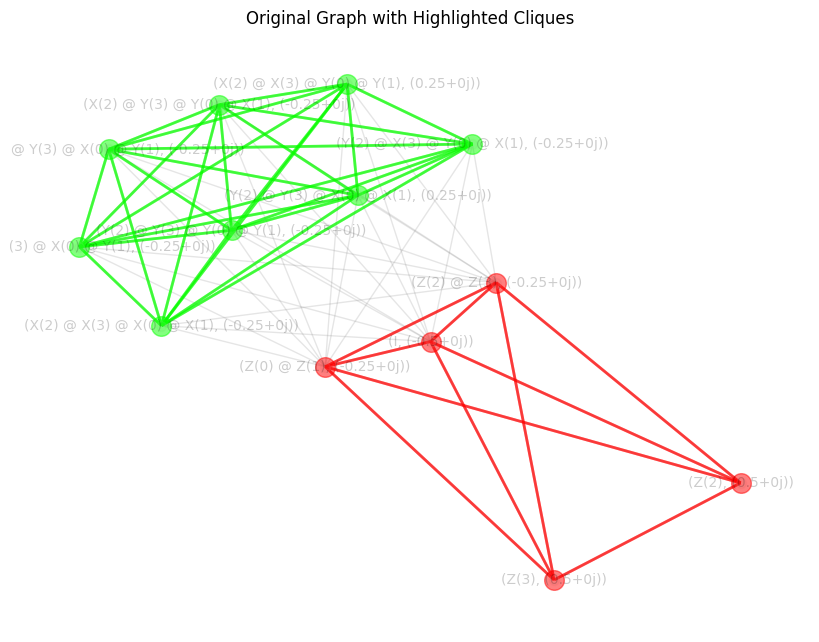

In [12]:
draw_cliquet_decomposition(G_base, cliques)

### Check Commutators
`test_internal_commutativity` and `test_commutativity_among_terms` are used to test commutation among internal terms of a single clique and among differnt cliques, respectively.

In [13]:
# Check that terms within a given clique commute
def test_internal_commutativity(H_term):

    all_commute = True
    split_sentences = {}
    for pauli_word, value in H_term.items():
        if pauli_word not in split_sentences:
            split_sentences[pauli_word] = qml.pauli.PauliSentence()

    # Iterate over all pairs of PauliSentences from split_sentences2 and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences.items(), 2):
        comm = qml.commutator(key1,key2, pauli=True)

        # Check if they commute
        if not np.allclose(comm.operation().matrix(), 0):
            all_commute = False

    return all_commute

# Check commutativity amongst all combinations of a given list of terms
def test_commutativity_among_terms(H_terms, verbose=False):

    num_terms = len(H_terms)

    for i in range(num_terms):
        for j in range(i + 1, num_terms):  # Check only unique pairs (i, j)
            ps1 = H_terms[i]
            ps2 = H_terms[j]

            # Compute the commutator using PennyLane
            comm = ps1.commutator(ps2)

            # Check if the commutator is empty (that is, if they commute)
            is_commuting = len(comm) == 0
            print(f"Term {i} and term {j} commute: ", is_commuting)
            if verbose:
                print(f"Term {i}: {ps1}")
                print(f"Term {j}: {ps2}")
                print(f"Commutator: {comm}")

In [14]:
print("Testing commutativity within each clique:")
for i in range(len(H_terms)):
    print("Terms within the", str(i) + "-th clique commute: ", test_internal_commutativity(H_terms[i]))

print("\nTesting commutativity amongst different hamiltonian terms:")
test_commutativity_among_terms(H_terms, verbose=False)


Testing commutativity within each clique:
Terms within the 0-th clique commute:  True
Terms within the 1-th clique commute:  True

Testing commutativity amongst different hamiltonian terms:
Term 0 and term 1 commute:  False


## Time Evolution

### Plotting Helper Functions

The following are helper functions for plotting of results.

In [15]:
# Plot the results
def plot_results(x, y, title="Results", label="Overlap", xlabel="Time", ylabel="Overlap", ylim=[0, 1.2]):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

# Plot the comparison between two result data sets
def plot_comparison(x, y1, y2, title="Results", label1="Data 1", label2="Data 2", xlabel="Time", ylabel="Overlap", ylim=[0, 1.2],
                    alpha=0.7, linestyle1="-", linestyle2="--"):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y1, label=label1, alpha=alpha, linestyle=linestyle1)
    plt.plot(x, y2, label=label2, alpha=alpha, linestyle=linestyle2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

# Plot the results in 3D
def plot_3D_on_plane(x, y, z , title="Results", xlabel="x_qty", ylabel="y_qty" , zlabel="z_qty", scatter=False):
    plt.figure()
    plt.figure(figsize=(8, 6))
    if scatter:
        plt.scatter(x, y, c=z, cmap='viridis', edgecolors='k')
    else:
        plt.imshow(z, cmap='viridis', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
    plt.colorbar(label=zlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x)
    plt.yticks(y)
    plt.show()

### Helper Functions
The following helper functions facilitate the conversion between pauli sentence and matrix representation of operators. We note the necessity of manually setting the wire order due to a known bug in the Pennylane library.

In [16]:
# get matrix form of a single pauli sentence
def get_matrix_from_ps(H_ps, n_qubits):
    order = list(range(n_qubits))
    for i in range(0,n_qubits):
        order[i]=i
    mat = qml.matrix(H_ps, wire_order=order)
    return mat

# get matrix form of a list of pauli sentences
# this function makes sure that the size of the matrices is correct
# by automatically adding implicit terms removed by Pennylane
def get_matrix_from_multiple_ps(ps_list, n_qubits):
    ps_list_implicit = []
    for term in ps_list:
        ps_list_implicit.append(add_implicit_terms(term, n_qubits))

    mat_list = []
    for term in ps_list_implicit:
        order = list(range(n_qubits))
        for i in range(0,n_qubits):
            order[i]=i
        mat_list.append(qml.matrix(term, wire_order=order))

    return mat_list

### Exact and Trotterized Evolution Function Declaration

The following functions implement the exact and trotterized time evolution. On top of the standard 1st order Trotter-Suzuki evolution given by

$e^{-i H t} \approx \left( e^{-i H_1 t / N} e^{-i H_2 t / N} \dots e^{-i H_n t / N} \right)^N$

we also implement the higher order versions where each trotter step is given by the following recursive folrmula

$\hat{O}_{2k}(t/n)=\hat{O}_{2k-2}^{2}\left(\left(4-4^{\frac{1}{2k-1}}\right)^{-1}t/n\right)\hat{O}_{2k-2}\left(\left(1-4\left(4-4^{\frac{1}{2k-1}}\right)^{-1}\right)t/n\right)\hat{O}_{2k-2}^{2}\left(\left(4-4^{\frac{1}{2k-1}}\right)^{-1}t/n\right)$

$\hat{O}_{2}(t/n)=e^{-iH_{1}\frac{t}{2n}}...e^{-iH_{n}\frac{t}{2n}}e^{-iH_{n}\frac{t}{2n}}...e^{-iH_{1}\frac{t}{2n}}$



In [17]:
# exact time evolution
def exact_evo(H, initial_state, t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t))
    evolved_state = U @ initial_state
    return evolved_state

# correlation function
def trotter_evo(H_terms_mat, initial_state, t, n, trotter_order=1):

    if trotter_order == 1:
        U = np.identity(H_terms_mat[0].shape[0])
        for _ in range(0, n):
            for term in H_terms_mat:
                U = U @ expm(-1j * term * (t/n))

        evolved_state = U @ initial_state
        return evolved_state

    else:
        
        if trotter_order%2 == 1: raise ValueError("Trotter order must be even or 1.")

        # recursive function to compute the trotter block
        def trotter_block(k, t, n):

            U = np.identity(H_terms_mat[0].shape[0])
            if k == 1: # second order (k=trotter_order/2 with trotter_order=2)
                for i in range(len(H_terms_mat)-1):
                    term = H_terms_mat[i]
                    U = U @ expm(-0.5j * term * (t/n))
                U = U @ expm(-1j * H_terms_mat[-1] * (t/n))

                for i in range(len((H_terms_mat))-2, -1, -1):
                    term = H_terms_mat[i]
                    U = U @ expm(-0.5j * term * (t/n))

                return U

            else: # 2k-th order of the suzuki-trotter
                u_k = 1/(4-4**(1/(2*k-1)))
                a = trotter_block(k-1, u_k * t, n)
                b = a @ a
                c = trotter_block(k-1, (1 - 4*u_k) * t, n)
                U = b @ c @ b
                return U

        U = np.identity(H_terms_mat[0].shape[0])
        block = trotter_block(trotter_order/2, t, n)
        for _ in range(n):
            U = U @ block

        return U @ initial_state

The following function are used to automatically calculate the correlations $\sigma_z(i,k) = \braket{\sigma_z^i \sigma_z^k} - \braket{\sigma_z^i} \braket{\sigma_z^k}$ between qubits given a list of states.

In [18]:
# compute correlation function
def correlation_function(evo, n_qubits=n_qubits, i=0, k=1):

    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zk_raw = qml.pauli.PauliWord({k:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw] = 1.0
    psk = qml.pauli.PauliSentence()
    psk[Zk_raw] = 1.0

    order = list(range(n_qubits))
    for s in range(0,n_qubits):
        order[s] = s

    Zi = qml.matrix(add_implicit_terms(psi, n_qubits), wire_order=order)
    Zk = qml.matrix(add_implicit_terms(psk, n_qubits), wire_order=order)

    sigma_ik = np.vdot(evo, Zi @ Zk @ evo) - np.vdot(evo ,Zi @ evo) * np.vdot(evo, Zk @ evo)
    sigma_ik = np.real(sigma_ik)
    return sigma_ik

In [19]:
# only calculates the first addend of the correlation function
def correlation_function_first_term_only(evo, n_qubits=n_qubits, i=0, k=1):

    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zk_raw = qml.pauli.PauliWord({k:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw] = 1.0
    psk = qml.pauli.PauliSentence()
    psk[Zk_raw] = 1.0

    order = list(range(n_qubits))
    for s in range(0,n_qubits):
        order[s] = s

    Zi = qml.matrix(add_implicit_terms(psi, n_qubits), wire_order=order)
    Zk = qml.matrix(add_implicit_terms(psk, n_qubits), wire_order=order)

    sigma_ik = np.vdot(evo, Zi @ Zk @ evo)
    sigma_ik = np.real(sigma_ik)
    return sigma_ik

The aim of the following functions is to automate the process of computing the evolution of states and related variables (like correlation and overlaps) for multiple timesteps

In [20]:
# Run the simulation with the exact time evolution
def run_simulation_exact(H, initial_state, times):
    states = []
    for t in times:
        state = exact_evo(H, initial_state, t)
        states.append(state)
    return states

# Run the simulation with the trotterized time evolution
def run_simulation_trotter(H_terms_mat, initial_state, times, n_trotter_steps, trotter_order):
    states = []
    for t in times:
        state = trotter_evo(H_terms_mat, initial_state, t, n_trotter_steps, trotter_order)
        states.append(state)
    return states

# Run the simulation with the trotterized time evolution with variable number of trotter steps
def run_simulation_trotter_variable_trotter_steps(H_terms_mat, initial_state, time, trotter_steps, trotter_order):
    states = []
    for n in trotter_steps:
        state = trotter_evo(H_terms_mat, initial_state, time, n, trotter_order)
        states.append(state)
    return states

# Get the correlations from the states
def get_correlations_from_states(states, n_qubits, i=0, k=1):
    correlations = []
    for state in states:
        correlation = correlation_function(state, n_qubits, i=i, k=k)
        correlations.append(correlation)
    return correlations

# Get the overlaps of set of states with a given target state
def get_overlap_from_states(states, target_state):
    overlaps = []
    for state in states:
        overlap = np.abs(np.vdot(state, target_state))**2
        overlaps.append(overlap)
    return overlaps

# Get the overlaps between two different sets of states
def get_overlap_between_states(states1, states2):
    overlaps = []
    for state1, state2 in zip(states1, states2):
        overlap = np.abs(np.vdot(state1, state2))**2
        overlaps.append(overlap)
    return overlaps

### Compute Evolution

In [21]:
# Compute exact time evolution
H_mat = get_matrix_from_ps(H_ps, n_qubits) 
exact_states = run_simulation_exact(H_mat, initial_state, times)
exact_overlaps = get_overlap_from_states(exact_states, initial_state)
exact_correlations = get_correlations_from_states(exact_states, n_qubits, i=0, k=1)

# Compute trotterized time evolution
H_mat_terms = get_matrix_from_multiple_ps(H_terms, n_qubits) 
trotter_states = run_simulation_trotter(H_mat_terms, initial_state, times, n_trotter_steps, trotter_order)
trotter_overlaps = get_overlap_from_states(trotter_states, initial_state)
trotter_correlations = get_correlations_from_states(trotter_states, n_qubits, i=0, k=1)

# Compare the results at each time step
exact_trotter_ovelaps = get_overlap_between_states(exact_states, trotter_states)

### Plot the results

The following graphs reproduce some of the results of the paper cited in the introduction. More specifically, here we report the graphs displaying the overlap with the initial state, the correlation and the error between exact and trotterized evolution.

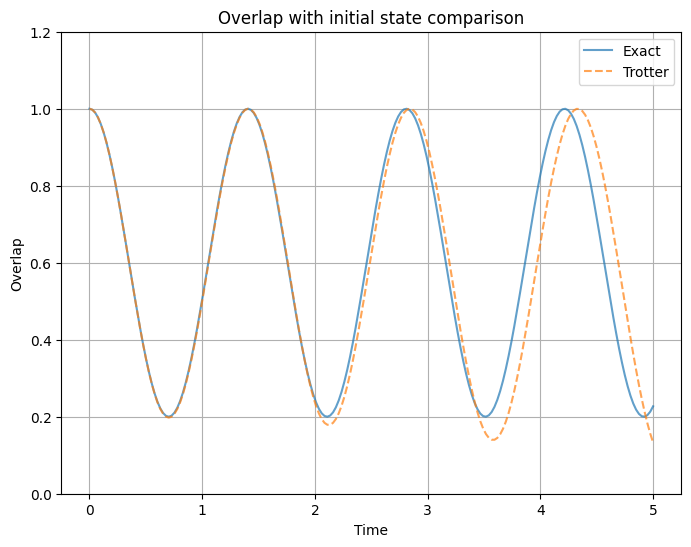

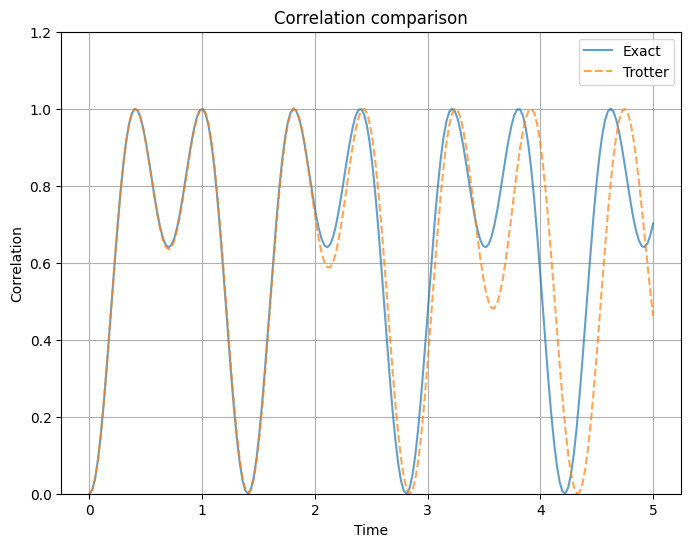

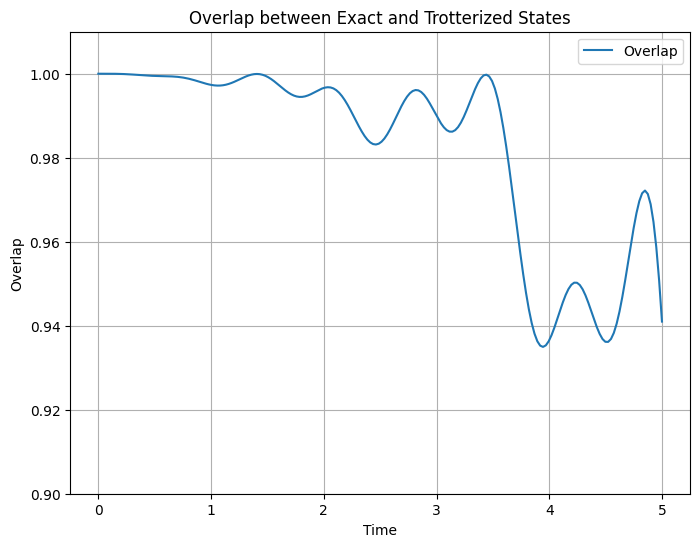

In [22]:
# Uncomment the following lines to plot the results singularly instead

# Plot the results for the exact time evolution
# plot_results(times, exact_overlaps, title="Exact Overlap")
# plot_results(times, exact_correlations, title="Exact Correlation", label="Correlation", ylabel="Correlation")

# Plot the results for the trotterized time evolution
# plot_results(times, trotter_overlaps, title="Trotter Overlap")
# plot_results(times, trotter_correlations, title="Trotter Correlation", label="Correlation", ylabel="Correlation")


# Uncomment the following lines to plot the results together

# Plot the comparison between exact and trotterized time evolution
plot_comparison(times, exact_overlaps, trotter_overlaps,
                title="Overlap with initial state comparison",
                label1="Exact",
                label2="Trotter",
                ylabel="Overlap",
                ylim=[0, 1.2])

# Plot the comparison of correlations obtained from exact and trotterized time evolution
plot_comparison(times, exact_correlations, trotter_correlations,
                title="Correlation comparison",
                label1="Exact", 
                label2="Trotter",
                ylabel="Correlation")

# Plot the scalar product of the states obtained from exact and trotterized time evolution
plot_results(times, exact_trotter_ovelaps,
             title="Overlap between Exact and Trotterized States",
             label="Overlap",
             ylabel="Overlap",
             ylim=[0.9, 1.01])

The following plot showing the overlap for variable number of trotter steps (at fixed time) reproduces another result from the paper cited above.

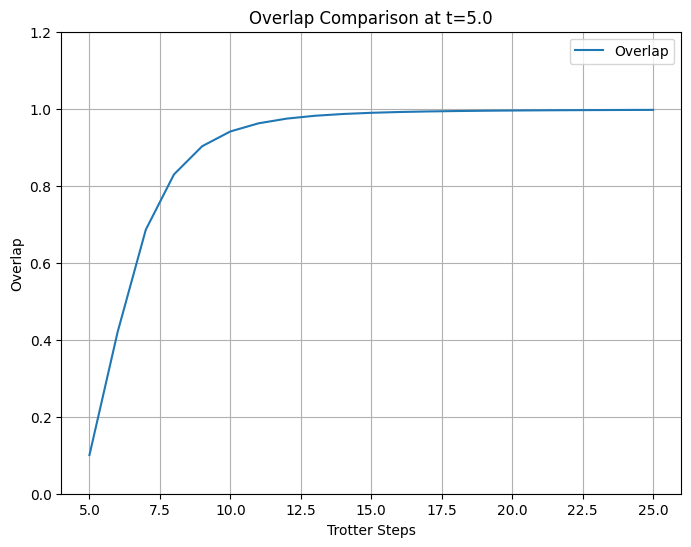

In [23]:
t_comparison = 5.0     # time at which the comparison is made
min_trotter_step = 5   # minimum number of trotter steps
max_trotter_step = 25  # maximum number of trotter steps
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)
trotter_states_variable_trotter_steps = run_simulation_trotter_variable_trotter_steps(H_mat_terms, initial_state, t_comparison, trotter_steps, trotter_order)
exact_state_at_t = exact_evo(H_mat, initial_state, t_max)
overlaps_variable_trotter_steps = get_overlap_from_states(trotter_states_variable_trotter_steps, exact_state_at_t)

plot_results(trotter_steps, overlaps_variable_trotter_steps,
             title="Overlap Comparison at t={}".format(t_comparison),
             label="Overlap",
             xlabel="Trotter Steps",
             ylabel="Overlap")


## Fidelity comparison

In this section we use the absolute value of the normalized kronecker product between two unitary operators (which is $F(U, V) = \frac{|\text{Tr}(U^\dagger V)|}{N}$) to extract information about the quality of the Trotter-Suzuki approximation compared to the exact evolution, indipendently from the initial state.

In [24]:
# Compute the fidelity
def fidelity(U1, U2):
    fidelity = np.abs(np.trace(U1.conj().T @ U2))/U1.shape[0]
    return fidelity 


### Fidelity evaluation functions
`get_fidelity_vs_time` returns the fidelity between exact-evolution operator and trotter-evolution operator at different values of time. `get_fidelity_vs_trotter_steps` returns the fidelity bewtween exact-evolution operator and trotter-evolution operator at a specific time for different trotter steps number.

In [25]:
# Compute the fidelity between the trotterized and exact time evolution at differnt times
def get_fidelity_vs_time(H_mat_terms, H_mat, times, n_trotter_steps, trotter_order):
    fidelity_product_list_vs_time = []
    initial_state = np.identity(2**n_qubits) # this way we can obtain the matrix of the evolution using the previusly defined function
    evo_trotter_list=run_simulation_trotter(H_mat_terms, initial_state, times, n_trotter_steps, trotter_order)
    evo_exact_list=run_simulation_exact(H_mat, initial_state, times)

    for i in range(0, len(times)):
        fidelity_product = fidelity(np.array(evo_trotter_list[i]), np.array(evo_exact_list[i]))
        fidelity_product_list_vs_time.append(fidelity_product)
    
    return fidelity_product_list_vs_time

# Compute the fidelity between the trotterized and exact time evolution at different trotter steps
def get_fidelity_vs_trotter_steps(H_mat_terms, H_mat, time, trotter_steps, trotter_order):
    fidelity_product_list_vs_trotter_steps = []
    initial_state= np.identity(2**n_qubits) # in this way we can obtain the matrix of the evolution using the previusly defined function
    evo_exact=exact_evo(H_mat, initial_state, time)
    evo_trotter_list=run_simulation_trotter_variable_trotter_steps(H_mat_terms, initial_state, time, trotter_steps, trotter_order)

    for i in range(0, len(trotter_steps)):
        fidelity_product = fidelity(np.array(evo_trotter_list[i]), np.array(evo_exact))
        fidelity_product_list_vs_trotter_steps.append(fidelity_product)
    
    return fidelity_product_list_vs_trotter_steps


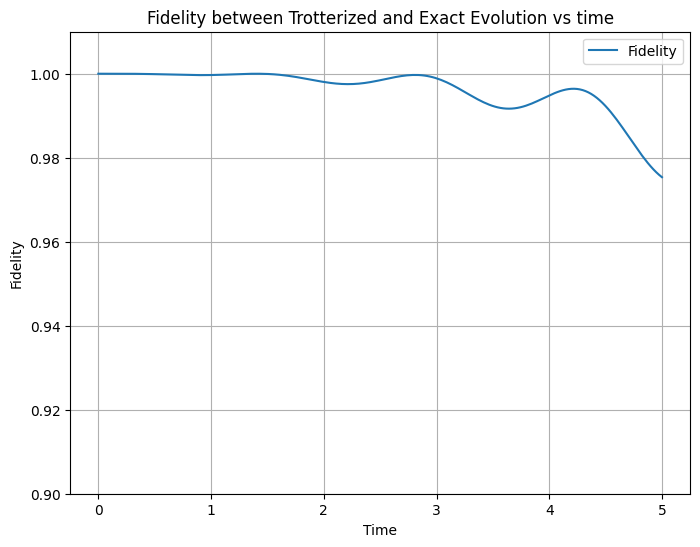

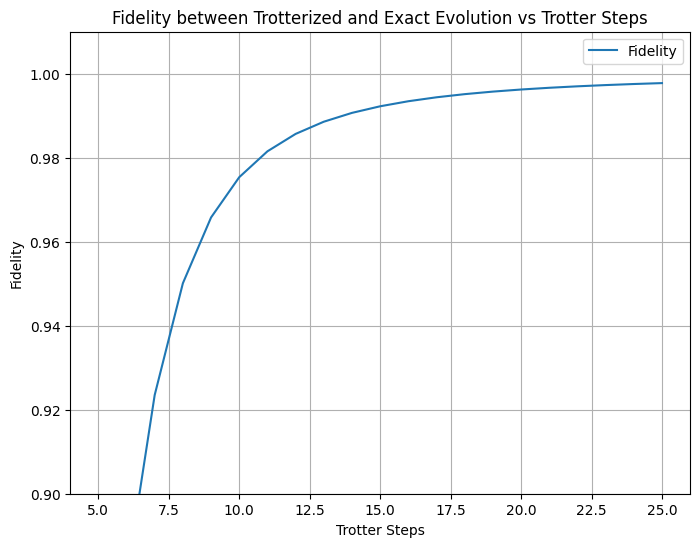

In [26]:

fidelity_product_list_vs_time = get_fidelity_vs_time(H_mat_terms, H_mat, times, n_trotter_steps, trotter_order)

plot_results(times, fidelity_product_list_vs_time,
                title="Fidelity between Trotterized and Exact Evolution vs time",
                label="Fidelity",
                xlabel="Time",
                ylabel="Fidelity",
                ylim=[0.9, 1.01])


fidelity_product_list_vs_trotter_steps = get_fidelity_vs_trotter_steps(H_mat_terms, H_mat, t_comparison, trotter_steps, trotter_order)

plot_results(trotter_steps, fidelity_product_list_vs_trotter_steps,
                title="Fidelity between Trotterized and Exact Evolution vs Trotter Steps",
                label="Fidelity",
                xlabel="Trotter Steps",
                ylabel="Fidelity",
                ylim=[0.9, 1.01])


## Phase transition study


In this section we focus on studying the phase diagram of the system

### Choose parameters for phase transition study
We define the parameters $\Sigma = \frac{\epsilon g}{2j-1}$ and $\Chi = \frac{\epsilon V}{2j-1}$ often used in the literature for studying the phase diagram study of the Agassi Model 

In [27]:
sigma_min = 0.0
sigma_max= 2.0
sigma_points_number = 25 # number of points for the sigma values

xi_min = 0.0
xi_max = 2.0
xi_points_number = 25 # number of points for the xi values

t_max = 8.0 # maximum time for the QPT study
time_steps = 150 # number of time steps for the QPT study


sigma_list = np.linspace(sigma_min, sigma_max, sigma_points_number)
xi_list = np.linspace(xi_min, xi_max, xi_points_number)
times = np.linspace(0, t_max, time_steps)


### Compute correlation evolution for different $\Sigma$ and $\Chi$

The functions below have the following purpuses:

 - `get_g_V_from_sigma_xi` returns $g$ and $V$ values, given the desired values of $\Sigma$ and $\Chi$ as input
 - `get_correlations_from_param_list_between_qbit_i_and_k` calculates the correlations at different time steps, given the lists of parameters between two specified qubits 
 - `cluster_data` applies the KMeans unsupervised clustering algorithm to the vectors consisting of the values of the correlation function at each time step. It also gives the option to compute clustering in fourier space.
 - `project_data_on_low_dimensional_space_PCA` project the data point on a low dimensional space using PCA dimensionality reduction.

In [28]:
# helper function to get g and V values from sigma and xi
def get_g_V_from_sigma_xi(sigma, xi, eps, j):
    g = sigma * eps / (2*j-1)
    V = xi * eps / (2*j-1)
    return g, V

# get the correlations between qubit i and k for different sigma and xi values
def get_correlations_from_param_list_between_qbit_i_and_k(initial_state, times, sigma_list, xi_list, n_qubits, i=0, k=1 , fourier_transform=False, verbose=False):
    correlations_list = []
    g_list, V_list = get_g_V_from_sigma_xi(sigma_list, xi_list, eps, j) #extrapolate g and v values
    progress = 0
    n_tot = len(g_list) * len(V_list)
    for g in g_list:
        for V in V_list:
            H = get_matrix_from_ps(qml.jordan_wigner(agassi_hamiltonian(j, eps, g, V), ps=True), n_qubits)
            states = run_simulation_exact(H, initial_state, times)
            correlations = get_correlations_from_states(states, n_qubits, i=i, k=k)
            if fourier_transform:
                correlations_list = fft(correlations_list)

            correlations_list.append(correlations)
            
            progress += 1
            if verbose:
                if progress % 10 == 0:
                    print(f"Progress: {progress}/{n_tot}")
        
    return correlations_list

# Use kmeans to divide the data into clusters
def cluster_data(data_set, n_clusters=3, seed=2435):
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans.fit(data_set)
    labels = kmeans.labels_
    return labels

# Perform PCA dimensionality reduction
def project_data_on_low_dimensional_space_PCA(data_set):
    reduced_data = PCA(n_components=2).fit_transform(data_set)
    return reduced_data



In [29]:
correlations_list=np.real(np.array(get_correlations_from_param_list_between_qbit_i_and_k(initial_state, times, sigma_list, xi_list, n_qubits, i=0, k=1, fourier_transform=False, verbose=False)))

### Maximum correlation amplitude with respect to g and V
The following functions reproduce a result from the paper cited in the introduction. In particular we plot the maximum amplitude reached by the correlation function in the given time period as a function of $\Sigma$, $\Chi$ and $\Sigma+\Chi$ (which in the case j=1 and $\epsilon=1$ is equal to $g+V$).

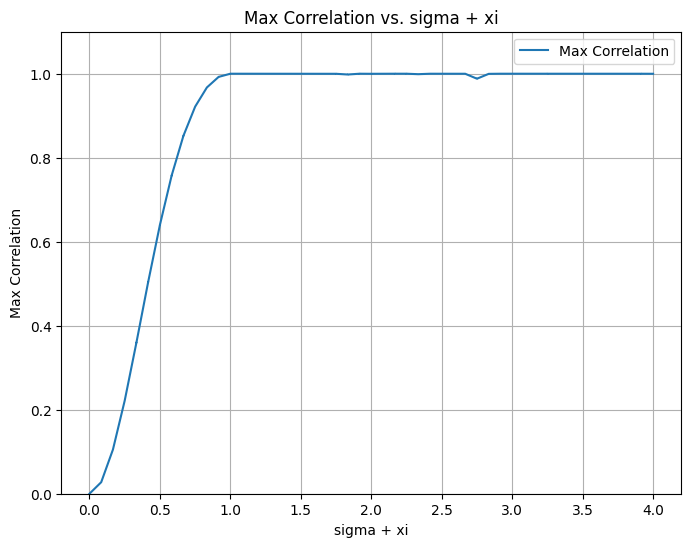

In [30]:
corr_max=np.max(correlations_list, axis=1) 
sigma_mesh, xi_mesh = np.meshgrid(sigma_list, xi_list)

# Compute g + V for each pair
sigma_xi_values = sigma_mesh.flatten() + xi_mesh.flatten()
corr_max_values = corr_max.flatten()

# Sort by g+V values
sorted_indices = np.argsort(sigma_xi_values)
sigma_xi_values_sorted = sigma_xi_values[sorted_indices]
corr_sorted = corr_max_values[sorted_indices]

plot_results(sigma_xi_values_sorted, corr_sorted, 
             title="Max Correlation vs. sigma + xi",
             label="Max Correlation",
             xlabel="sigma + xi",
             ylabel="Max Correlation",      
             ylim=[0.0, 1.1])

<Figure size 640x480 with 0 Axes>

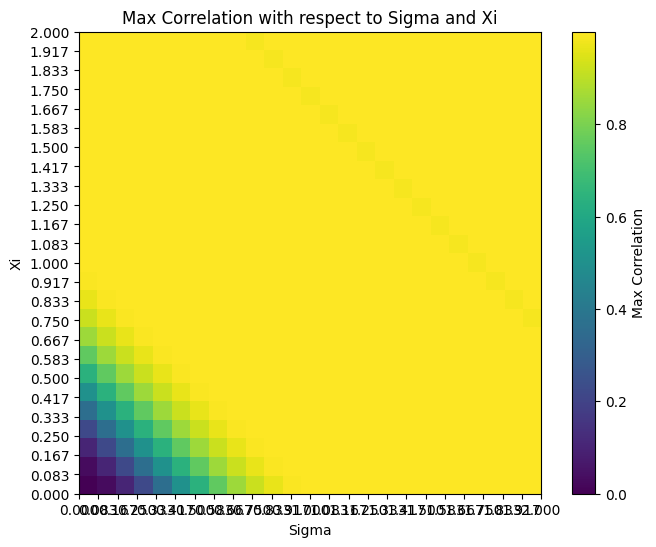

In [31]:
corr_max=corr_max.reshape(sigma_points_number, xi_points_number)

plot_3D_on_plane(sigma_list, xi_list, corr_max, 
                 title="Max Correlation with respect to Sigma and Xi", 
                 xlabel="Sigma", 
                 ylabel="Xi", 
                 zlabel="Max Correlation")



### Clustering on correlation functions
We now compute and plot the result of the clusterisation. Each color refers to a different cluster 

<Figure size 640x480 with 0 Axes>

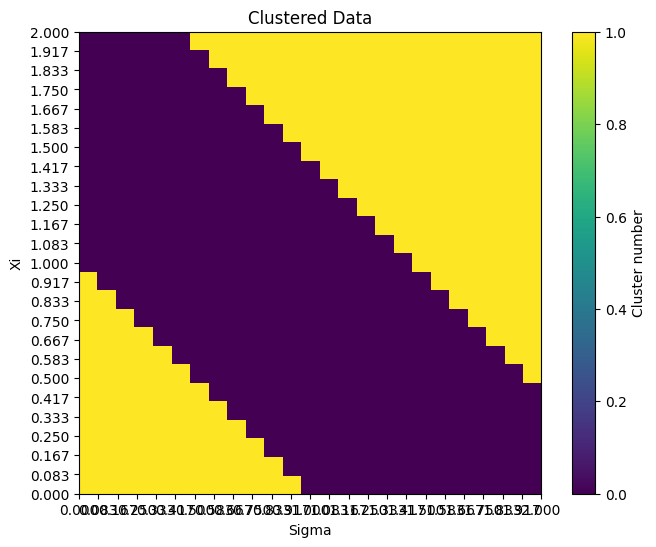

In [32]:

labels=cluster_data(data_set=correlations_list, n_clusters=2, seed=10)
labels_matrix=labels.reshape(len(sigma_list), len(xi_list))

plot_3D_on_plane(sigma_list, xi_list, labels_matrix,
                    title="Clustered Data",
                    xlabel="Sigma",
                    ylabel="Xi",
                    zlabel="Cluster number")

### Visualization of data set on lower dimensional space
We perform PCA dimensionality reduction. 

<Figure size 640x480 with 0 Axes>

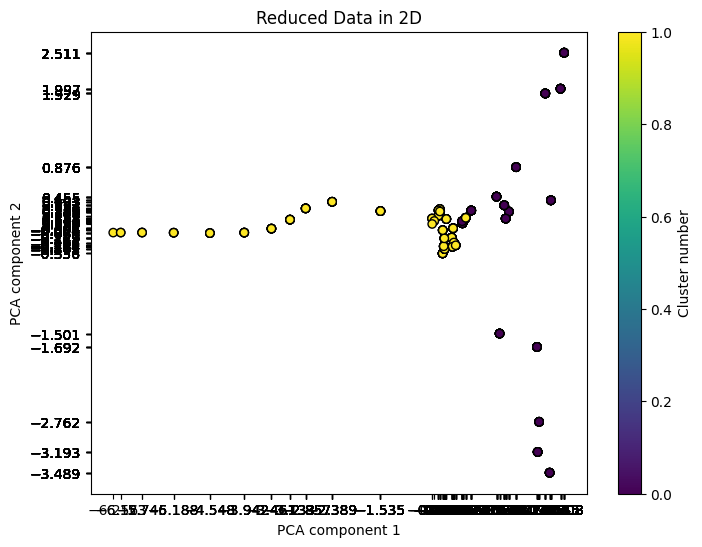

In [33]:
correlation_reduced=project_data_on_low_dimensional_space_PCA(correlations_list)

plot_3D_on_plane(correlation_reduced[:,0], correlation_reduced[:,1], labels,
                    title="Reduced Data in 2D",
                    xlabel="PCA component 1",
                    ylabel="PCA component 2",
                    zlabel="Cluster number",
                    scatter=True)
                 

## Extras

The following two cells have been used to explore the evolution and to choose the initial state and the qubits which we want to evaluate the correlations in a sensible way for.

### Look for evolving states

In [34]:
# get initial state
def get_initial_state(v):
    initial_state = np.zeros(2**n_qubits, dtype=complex)
    initial_state[v] = 1
    return initial_state

# get the overlap per qubit at a given time
def get_overlap_per_qubit_at_time_t(t):
    for v in range(0,2**n_qubits):
        initial_state=get_initial_state(v)
        print(v, np.abs(np.vdot(initial_state, exact_evo(H=H_mat, initial_state=initial_state, t=t))**2))

get_overlap_per_qubit_at_time_t(5.0)

0 1.0
1 1.0000000000000004
2 1.0000000000000004
3 0.22700129259554946
4 1.0000000000000004
5 1.0
6 1.0
7 0.9999999999999997
8 1.0000000000000004
9 1.0
10 1.0
11 0.9999999999999997
12 0.22700129259554927
13 1.0000000000000004
14 1.0000000000000004
15 0.999999999999999


### Check which qubits are correlated

In [35]:
# get the correlation per qubit at a given time
def get_correlation_per_qubit_at_time_t(t):
    correlations_between_qubits = []
    for i in range(0, n_qubits):
        for k in range(0, i+1):
            evo=exact_evo(H=H_mat, initial_state=initial_state, t=5.0)
            corr=correlation_function(evo=evo, n_qubits=n_qubits ,i=i, k=k)
            corr_only_first_term=correlation_function_first_term_only(evo=evo, n_qubits=n_qubits ,i=i, k=k)
            print(i, k, corr, corr_only_first_term)

get_correlation_per_qubit_at_time_t(5.0)

0 0 0.7018868230219962 1.0
1 0 0.7018868230219962 1.0
1 1 0.7018868230219962 1.0
2 0 -0.7018868230219962 -1.0
2 1 -0.7018868230219962 -1.0
2 2 0.7018868230219962 1.0
3 0 -0.7018868230219962 -1.0
3 1 -0.7018868230219962 -1.0
3 2 0.7018868230219962 1.0
3 3 0.7018868230219962 1.0
